In [1]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW
from scipy.optimize import minimize, fsolve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import os
import gc
from tqdm import tqdm
import sys
sys.path.append("../src")
from config import read_config, update_config
from metric import cal_mae_metric
from dataset import read_data
from util import smart_avg

In [2]:
config = read_config("Base")
config.gpu = [1]
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/Base/


In [3]:
subs = {
    "Public_PulpFriction_New": "../output/Public_PulpFriction_New/test_pred_all_16657.csv",
    
    "LSTM5_REG_PL_better": "../output/LSTM5_REG_PL_better/test_pred_all_17937.csv",    
    "LSTM5_REG_physics_PL_better_2": "../output/LSTM5_REG_physics_PL_better_2/test_pred_all_17501.csv",
    
    "LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL": "../output/LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL/test_pred_all_17199.csv"
    "LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3":"../output/LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3/test_pred_all_17404.csv",
    "LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3": "../output/LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3/test_pred_all_17136.csv",
}
ensemble_folder = config.output_folder + "/" + "ensemble_1101_all"
if not os.path.exists(ensemble_folder):
    
    os.makedirs(ensemble_folder)

In [4]:
train, test = read_data(config)

In [5]:
pressure_unique = np.load("/home/vincent/Kaggle/GBVPP/input/pressure_unique.npy")

In [23]:
P_MIN = np.min(pressure_unique)
P_MAX = np.max(pressure_unique)
P_STEP = pressure_unique[1] - pressure_unique[0]
def transform_p(x):
    t = ((x - P_MIN) // P_STEP * P_STEP + P_MIN)
    return min(max(t, P_MIN), P_MAX)

def transform_pv(s):
    t = (np.round((s - P_MIN) / P_STEP) * P_STEP + P_MIN)
    return np.clip(t, P_MIN, P_MAX)

In [24]:
sub_all = None
for key, sub_file in tqdm(subs.items()):
    train[key] = 0
    tmp = pd.read_csv(sub_file)
    if sub_all is None:
        sub_all = tmp[["id","pressure"]].copy()
        sub_all["pressure"] = 0
        
    for fold in range(5):
        if "Public_PulpFriction_New" == key:
            train.loc[train.query(f"fold=={fold}").index, key] = np.load(f'../output/{key}/oof{fold}.npy').flatten()
        else:
            train.loc[train.query(f"fold=={fold}").index, key] = torch.load(f'../output/{key}/Fold_{fold}_best_model.pth')['valid_preds'].flatten()
        sub_all[key+f"_{fold}"] = tmp[f"preds_fold{fold}"]
    train[key] = transform_pv(train[key])
    sub_all[key] = smart_avg(sub_all[[key+f"_{f}" for f in range(5)]],axis=1)
    sub_all[key] = transform_pv(sub_all[key])

  0%|                                                                                     | 0/5 [00:00<?, ?it/s]

Inliers:  3565273 -> compute mean
Outliers:  458727 -> compute median
Total:    4024000


 20%|███████████████▍                                                             | 1/5 [00:03<00:14,  3.60s/it]

Inliers:  3897721 -> compute mean
Outliers:  126279 -> compute median
Total:    4024000


 40%|██████████████████████████████▊                                              | 2/5 [00:07<00:11,  3.77s/it]

Inliers:  3909208 -> compute mean
Outliers:  114792 -> compute median
Total:    4024000


 60%|██████████████████████████████████████████████▏                              | 3/5 [00:12<00:08,  4.17s/it]

Inliers:  1754681 -> compute mean
Outliers: 2269319 -> compute median
Total:    4024000


 80%|█████████████████████████████████████████████████████████████▌               | 4/5 [00:17<00:04,  4.67s/it]

Inliers:  1645905 -> compute mean
Outliers: 2378095 -> compute median
Total:    4024000


100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.62s/it]


In [25]:
for key, sub_file in subs.items():
    CV = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df[key],1-df["u_out"])).mean()
    print(f"Model {key} CV {CV:.5f}")

Model Public_PulpFriction_New CV 0.16499
Model LSTM5_REG_PL_better CV 0.17937
Model LSTM5_REG_physics_PL_better_2 CV 0.17501
Model LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3 CV 0.17404
Model LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3 CV 0.17136


In [30]:
model_cols = list(subs.keys())
train["oof_avg"] =  transform_pv(train[model_cols].mean(axis=1))
train["oof_median"] =  transform_pv(train[model_cols].median(axis=1))
train["oof_smart"] =  transform_pv(smart_avg(train[model_cols], axis=1))
for key in ['oof_avg', 'oof_median', 'oof_smart']:
    CV = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df[key],1-df["u_out"])).mean()
    print(f"{key} CV {CV:.5f}")

Inliers:  2034927 -> compute mean
Outliers: 4001073 -> compute median
Total:    6036000
oof_avg CV 0.15561
oof_median CV 0.15459
oof_smart CV 0.15392


In [31]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,Public_PulpFriction_New,LSTM5_REG_PL_better,LSTM5_REG_physics_PL_better_2,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,pressure_smart,oof_avg,oof_median,oof_smart
0,1,1,20,50,0.000000,0.083334,0,5.837492,4,5.837492,5.767190,5.767190,5.767190,5.767190,5.767190,5.767190,5.767190,5.767190
1,2,1,20,50,0.033652,18.383041,0,5.907794,4,5.978096,5.837492,5.837492,5.837492,5.837492,5.907794,5.837492,5.837492,5.837492
2,3,1,20,50,0.067514,22.509277,0,7.876254,4,8.016858,7.876254,7.946556,7.876254,7.876254,7.946556,7.946556,7.876254,7.946556
3,4,1,20,50,0.101542,22.808823,0,11.742872,4,11.883476,11.742872,11.813174,11.883476,11.883476,11.813174,11.813174,11.883476,11.813174
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,12.375591,12.516196,12.516196,12.516196,12.445893,12.445893,12.445893,12.516196,12.445893


In [32]:
sub_all.head()

,id,pressure,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New,LSTM5_REG_PL_better_0,LSTM5_REG_PL_better_1,...,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3_2,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3_3,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_0,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_1,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_2,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3
0,1,0,6.297967,6.315374,6.320640,6.227913,6.300588,6.259305,6.329606,6.259304,...,6.259305,6.259305,6.259305,6.259305,6.259305,6.189002,6.259305,6.259305,6.189002,6.259305
1,2,0,5.987489,5.982381,5.996212,5.917186,5.982573,5.978096,5.978096,5.978096,...,5.907794,5.907794,5.907794,5.907794,5.907794,5.907794,5.907794,5.907794,5.978096,5.907794
2,3,0,7.048677,7.147728,7.079803,7.086129,7.157315,7.102930,7.102930,7.102930,...,7.102930,7.102930,7.102930,7.102930,7.032628,7.173232,7.102930,7.102930,7.102930,7.102930
3,4,0,7.596078,7.761950,7.575807,7.577055,7.637226,7.595045,7.595045,7.665347,...,7.595045,7.665347,7.595045,7.595045,7.595045,7.665347,7.524743,7.665347,7.665347,7.595045
4,5,0,9.124584,9.207625,9.030670,9.131549,9.165101,9.141693,9.141692,9.141692,...,9.071390,9.071390,9.071390,9.071390,9.071390,9.141693,9.001088,9.141693,9.071390,9.071390


['Public_PulpFriction_New', 'LSTM5_REG_PL_better', 'LSTM5_REG_physics_PL_better_2', 'LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3', 'LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3'] (6036000, 8)
Inital Blend OOF: -0.155607
Optimised Blend OOF: -0.154189
----------------------------------------------------------------------
Public_PulpFriction_New                  Optimised Weights: 0.3476972049460615
LSTM5_REG_PL_better                      Optimised Weights: 0.21913777383927804
LSTM5_REG_physics_PL_better_2            Optimised Weights: 0.1037610848781544
LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3 Optimised Weights: 0.13583249045269577
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3 Optimised Weights: 0.19324280188590431


<AxesSubplot:>

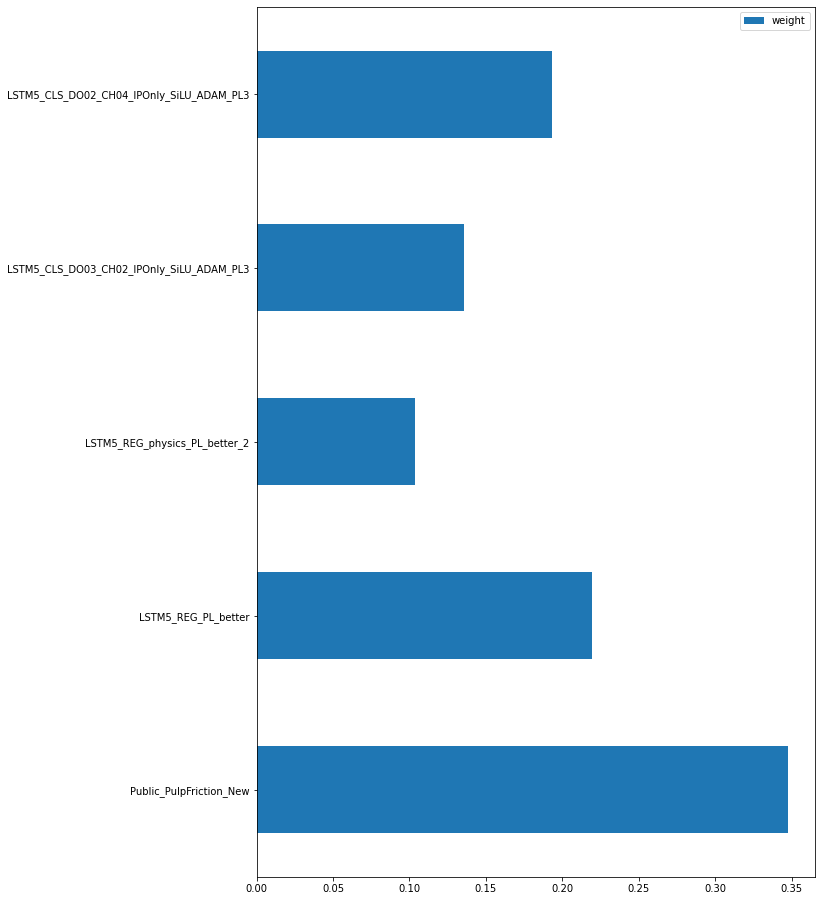

In [28]:
# weight optimization here .....
sci_opt_preds = train[model_cols + ["pressure","u_out","fold"]].copy() 
X = sci_opt_preds[model_cols].values
print(model_cols, sci_opt_preds.shape)
def get_score(weights, oof=sci_opt_preds):
    weights = np.array(weights)
    oof["prediction"] = (weights * X).sum(axis=1)
    oof["prediction"] = transform_pv(oof["prediction"])
    return oof.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["prediction"],1-df["u_out"])).mean()

tol = 1e-10
init_guess = [1 / len(model_cols)] * len(model_cols)
bnds = [(-1, 1) for _ in range(len(model_cols))]
print('Inital Blend OOF: {:.6f}'.format(-get_score(init_guess)))
res_scipy = minimize(fun = get_score, 
                    x0 = init_guess, 
                    method = 'Nelder-Mead', 
                    bounds = bnds, 
                    tol = tol)
print('Optimised Blend OOF: {:.6f}'.format(-res_scipy.fun))
sci_cv_score = -res_scipy.fun
print('-' * 70)
for n, key in enumerate(model_cols):
    print(f'{key:40s} Optimised Weights:', res_scipy.x[n])
ws = res_scipy.x 
pd.DataFrame(dict(zip(model_cols,ws)),index=["weight"]).T.plot(kind="barh",figsize=(10,16))

In [33]:
# weights here ....        
#train["pressure_smart"] = transform_pv((train[list(subs.keys())] * ws).sum(axis=1))
train["pressure_smart"] = transform_pv(smart_avg(train[list(subs.keys())],axis=1))
CVs = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["pressure_smart"],1-df["u_out"]))
CV = np.mean(CVs)
print(CVs)
print("Ensemble CV: Mean {:.4f}, std {:.4f}".format(np.mean(CVs), np.std(CVs)))

Inliers:  2034927 -> compute mean
Outliers: 4001073 -> compute median
Total:    6036000
fold
0    0.157437
1    0.151371
2    0.151494
3    0.154488
4    0.154789
dtype: float64
Ensemble CV: Mean 0.1539, std 0.0023


In [34]:
id_score = train.groupby("breath_id").apply(lambda df: cal_mae_metric(df["pressure"], df["pressure_smart"],1-df["u_out"]))

In [35]:
id_score.describe()

count    7.545000e+04
mean     1.528221e-01
std      2.488917e-01
min      1.290612e-12
25%      6.060530e-02
50%      9.212005e-02
75%      1.542112e-01
max      2.028217e+01
dtype: float64

In [36]:
np.sum(id_score > 1)

905

In [37]:
good_ids = list(id_score[id_score < 1].index)

In [38]:
good_train = train.query(f"breath_id in {good_ids}")

In [39]:
CVs_good = good_train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3"],1-df["u_out"]))
CV_good = np.mean(CVs_good)
print(CVs_good)

fold
0    0.157495
1    0.152886
2    0.155672
3    0.156048
4    0.153016
dtype: float64


In [40]:
CV_good

0.15502331782890422

In [41]:
# len(id_score)

In [18]:
# drop_id_1 = np.array(id_score[id_score > 1].index)
# drop_id_2 = np.array(id_score[id_score > 2].index)
# np.save("../input/large_error_id_1", drop_id_1)
# np.save("../input/large_error_id_2", drop_id_2)

In [42]:
for fold in tqdm(range(5)):
    sub_keys = [key+f"_{fold}" for key in subs.keys()]
    #test_fold_pred = transform_pv((sub_all[sub_keys] * ws).sum(axis=1))
    test_fold_pred = transform_pv(smart_avg(sub_all[sub_keys], axis=1))
    sub_fold = sub_all[["id"]].copy()
    sub_fold[f'preds_fold{fold}'] = test_fold_pred
    sub_fold.to_csv(ensemble_folder + f"/test_fold{fold}.csv",index=False)

#sub_all["pressure"] = transform_pv((sub_all[model_cols] * ws).sum(axis=1))
sub_all["pressure"] = transform_pv(smart_avg(sub_all[model_cols], axis=1))
sub_all.to_csv(ensemble_folder + f"/sub_all_{CV*1e5:.0f}.csv")
sub_all[["id","pressure"]].to_csv(ensemble_folder + f"/submission_{CV*1e5:.0f}.csv",index=False)
print(sub_all.shape, train.shape)
sub_all

  0%|                                                                                     | 0/5 [00:00<?, ?it/s]

Inliers:  1438946 -> compute mean
Outliers: 2585054 -> compute median
Total:    4024000


 20%|███████████████▍                                                             | 1/5 [00:06<00:25,  6.32s/it]

Inliers:  1447003 -> compute mean
Outliers: 2576997 -> compute median
Total:    4024000


 40%|██████████████████████████████▊                                              | 2/5 [00:12<00:18,  6.22s/it]

Inliers:  1439551 -> compute mean
Outliers: 2584449 -> compute median
Total:    4024000


 60%|██████████████████████████████████████████████▏                              | 3/5 [00:18<00:12,  6.10s/it]

Inliers:  1446165 -> compute mean
Outliers: 2577835 -> compute median
Total:    4024000


 80%|█████████████████████████████████████████████████████████████▌               | 4/5 [00:24<00:06,  6.09s/it]

Inliers:  1444167 -> compute mean
Outliers: 2579833 -> compute median
Total:    4024000


100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.12s/it]


Inliers:  1484794 -> compute mean
Outliers: 2539206 -> compute median
Total:    4024000
(4024000, 32) (6036000, 18)


,id,pressure,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New,LSTM5_REG_PL_better_0,LSTM5_REG_PL_better_1,...,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3_2,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3_3,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_0,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_1,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_2,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3
0,1,6.259305,6.297967,6.315374,6.320640,6.227913,6.300588,6.259305,6.329606,6.259304,...,6.259305,6.259305,6.259305,6.259305,6.259305,6.189002,6.259305,6.259305,6.189002,6.259305
1,2,5.907794,5.987489,5.982381,5.996212,5.917186,5.982573,5.978096,5.978096,5.978096,...,5.907794,5.907794,5.907794,5.907794,5.907794,5.907794,5.907794,5.907794,5.978096,5.907794
2,3,7.102930,7.048677,7.147728,7.079803,7.086129,7.157315,7.102930,7.102930,7.102930,...,7.102930,7.102930,7.102930,7.102930,7.032628,7.173232,7.102930,7.102930,7.102930,7.102930
3,4,7.595045,7.596078,7.761950,7.575807,7.577055,7.637226,7.595045,7.595045,7.665347,...,7.595045,7.665347,7.595045,7.595045,7.595045,7.665347,7.524743,7.665347,7.665347,7.595045
4,5,9.071390,9.124584,9.207625,9.030670,9.131549,9.165101,9.141693,9.141692,9.141692,...,9.071390,9.071390,9.071390,9.071390,9.071390,9.141693,9.001088,9.141693,9.071390,9.071390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,4023996,6.259305,6.155486,6.287960,6.178166,6.289627,6.211693,6.259305,0.002414,0.002414,...,12.516196,18.140367,12.656800,14.765864,11.672570,14.133145,14.484656,11.813174,16.593720,14.133145
4023996,4023997,6.259305,6.349664,6.205312,6.254850,6.213360,6.290364,6.259305,0.002414,0.002414,...,11.883476,18.070065,12.797404,14.765864,11.672570,12.938008,14.554958,11.883476,13.641030,12.938008
4023997,4023998,6.470211,6.351519,6.484034,6.444641,6.469348,6.476368,6.470211,0.002414,0.002414,...,11.883476,18.140367,12.938008,14.344051,12.024081,13.359821,14.554958,12.305289,13.781634,13.359821
4023998,4023999,6.189002,6.155175,6.271890,6.167885,6.279932,6.199571,6.189002,0.002414,0.002414,...,12.024081,18.140367,12.938008,14.554958,14.133145,15.890699,14.554958,12.727102,13.781634,14.133145
